In [334]:
import numpy as np
from queue import Queue
from collections import defaultdict
import networkx as nx
from networkx import DiGraph


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

import torchvision
from torchvision import datasets, transforms


from genotype.genotype import RandomArchitectureGenerator

from genotype.base_pairs import ConvNode, MaxPoolNode, AvgPoolNode, SumNode, ConcatNode, InputNode, Node

In [335]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [363]:
rag = RandomArchitectureGenerator(min_depth=10, max_depth=75)

In [364]:
g, att = rag.get_architecture(reset_on_finish=False)

Final depth:6
Number of nodes:12


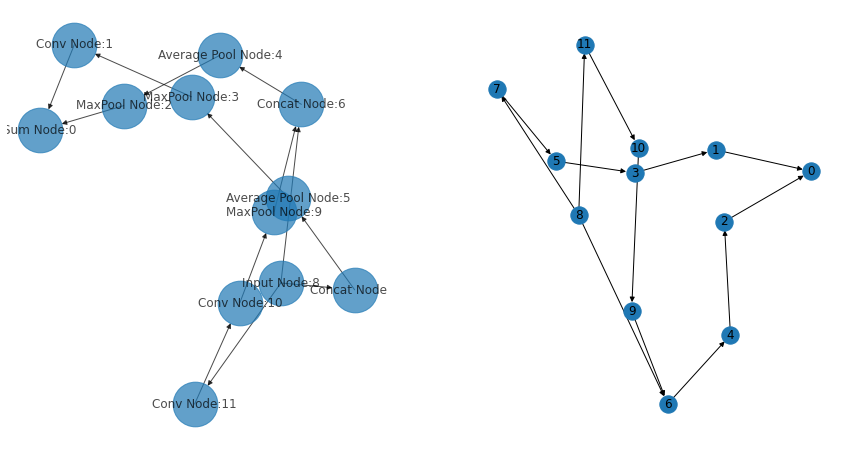

In [365]:
rag.show(g.reverse(), att, labels='both')

In [358]:
in_node = rag.input_nodes
in_node

9

In [367]:
input_to_network = att[in_node]
input_to_network

{'predecessors': [{'predecessors': [{'predecessors': [{'predecessors': [{'predecessors': [], 'successors': [{'predecessors': [{...}], 'successors': [{'predecessors': [{...}], 'successors': [{'predecessors': [{...}], 'successors': [{'predecessors': [{...}], 'successors': [{'predecessors': [{...}, {'predecessors': [{'predecessors': [{...}], 'successors': [{...}], 'inputs': {}, 'processed_inputs': {}, 'in_channels': 32, 'out_channels': 128, 'in_height': 124, 'out_height': 124, 'in_width': 124, 'out_width': 124, 'function': <function ConvNode.get_function.<locals>.conv_block at 0x0000019258C8D940>, 'node_id': 10, 'arity': 1, 'num_inputs': 1, 'initialised': True, 'name': 'Conv Node', 'padding': 1, 'stride': 1, 'kernel': 3, 'dilation': 1, 'pad_mode': None}], 'successors': [{...}], 'inputs': {}, 'processed_inputs': {}, 'in_channels': 3, 'out_channels': 32, 'in_height': 128, 'out_height': 124, 'in_width': 128, 'out_width': 124, 'function': <function ConvNode.get_function.<locals>.conv_block at

In [362]:
att[0].in_channels

{}

In [188]:
rag.reset()

In [25]:
def get_torch_layer(attributes):
    return attributes

In [54]:
layers = []
for node in g.nodes:
    print(node)
    print(tuple(g.successors(node)))
    a[node]['IN_CHANNELS'] = [a[x]['OUT_CHANNELS'] for x in g.successors(node) if 'OUT_CHANNELS' in a[x]]

0
(1,)
1
(2,)
2
(3,)
3
(4, 5)
4
(6,)
5
()
6
(7, 8)
7
(8,)
8
(9,)
9
(10, 11)
10
(12,)
11
()
12
(13, 14)
13
(15,)
14
()
15
()


In [232]:
a = att.copy()
a

defaultdict(dict,
            {0: {'TYPE': 'SUM',
              'ARITY': 2,
              'IN_CHANNELS': [512],
              'OUT_CHANNELS': 1,
              'IN_WIDTH': [64],
              'OUT_WIDTH': [64]},
             1: {'TYPE': 'MAX',
              'ARITY': 1,
              'KERNEL': 7,
              'PADDING': 0,
              'PADDING_MODE': 'replicate'},
             2: {'TYPE': 'CONV',
              'ARITY': 1,
              'KERNEL': 3,
              'PADDING': 0,
              'PADDING_MODE': 'replicate',
              'OUT_CHANNELS': 512},
             3: {'TYPE': 'CONV',
              'ARITY': 1,
              'KERNEL': 3,
              'PADDING': 1,
              'PADDING_MODE': 'replicate',
              'OUT_CHANNELS': 256},
             4: {'TYPE': 'INPUT',
              'ARITY': 0,
              'IN_CHANNELS': 3,
              'OUT_CHANNELS': 3,
              'IN_WIDTH': [128],
              'OUT_WIDTH': [128]},
             5: {'TYPE': 'MAX',
              'ARITY'

In [171]:
def get_width(graph, attributes, node):
    width = []
    suc_gen = [suc for suc in graph.successors(node)]
    i=0
    while not width and i < len(suc_gen):
        suc = suc_gen[i]
        if 'OUT_WIDTH' in attributes[suc]:
            width.extend(attributes[suc]['OUT_WIDTH'])
        i+=1
    i=0   
    while not width and i < len(suc_gen):
        suc = suc_gen[i]
        width = get_width(graph, attributes, suc)
        i+=1

    return width

In [197]:
def _format_architecture(node_set, graph, attributes, imshape):
    for node in node_set:
        if attributes[node]['TYPE'] == 'INPUT':
            attributes[node]['IN_CHANNELS'] = 3
            attributes[node]['OUT_CHANNELS'] = 3
            attributes[node]['IN_WIDTH'] = [imshape]
            attributes[node]['OUT_WIDTH'] = [imshape]
        else:
            attributes[node]['IN_CHANNELS'] = [attributes[x]['OUT_CHANNELS'] for x in graph.successors(node) if 'OUT_CHANNELS' in attributes[x]]
            width = get_width(graph, attributes, node)
            if attributes[node]['TYPE'] in {'MAX', 'AVERAGE'}:
                attributes[node]['IN_WIDTH'] = width
                attributes[node]['OUT_WIDTH'] = [int((min(width) + 2*attributes[node]['PADDING'] - (attributes[node]['KERNEL']-1))/2)]
            elif attributes[node]['TYPE'] == 'CONV': 
                attributes[node]['IN_WIDTH'] = width
                attributes[node]['OUT_WIDTH'] = [int((min(width) + 2*attributes[node]['PADDING'] - (attributes[node]['KERNEL']-1))/2)]
            elif attributes[node]['TYPE'] == 'SUM':
                attributes[node]['OUT_CHANNELS'] = 1
                attributes[node]['IN_WIDTH'] = width
                attributes[node]['OUT_WIDTH'] = [min(width)]
            elif attributes[node]['TYPE'] == 'CONCAT':
                attributes[node]['OUT_CHANNELS'] = sum(attributes[node]['IN_CHANNELS'])
                attributes[node]['IN_WIDTH'] = width
                attributes[node]['OUT_WIDTH'] = [min(width)]
        return attributes

In [222]:
def format_architecture(graph, attributes, imshape):
    #potential improvement to include padding, stride and dilation
    input_nodes = [x for x in graph.nodes if attributes[x]['TYPE']=='INPUT']
    non_input_nodes = [x for x in graph.nodes if attributes[x]['TYPE']!='INPUT']
    
    attributes = _format_architecture(input_nodes, graph, attributes, imshape)
    attributes = _format_architecture(non_input_nodes, graph, attributes, imshape)
    
    return attributes

In [223]:
a = att.copy()
a_f = format_architecture(g, a, imshape)
a_f

defaultdict(dict,
            {0: {'TYPE': 'SUM',
              'ARITY': 2,
              'IN_CHANNELS': [512],
              'OUT_CHANNELS': 1,
              'IN_WIDTH': [64],
              'OUT_WIDTH': [64]},
             1: {'TYPE': 'MAX',
              'ARITY': 1,
              'KERNEL': 7,
              'PADDING': 0,
              'PADDING_MODE': 'replicate'},
             2: {'TYPE': 'CONV',
              'ARITY': 1,
              'KERNEL': 3,
              'PADDING': 0,
              'PADDING_MODE': 'replicate',
              'OUT_CHANNELS': 512},
             3: {'TYPE': 'CONV',
              'ARITY': 1,
              'KERNEL': 3,
              'PADDING': 1,
              'PADDING_MODE': 'replicate',
              'OUT_CHANNELS': 256},
             4: {'TYPE': 'INPUT',
              'ARITY': 0,
              'IN_CHANNELS': 3,
              'OUT_CHANNELS': 3,
              'IN_WIDTH': [128],
              'OUT_WIDTH': [128]},
             5: {'TYPE': 'MAX',
              'ARITY'

In [205]:
def _get_conv_block(conv_node):
    def conv_block(x):
        x = nn.Conv2d(
            in_channels = conv_node['IN_CHANNELS'][0],
            out_channels = conv_node['OUT_CHANNELS'],
            kernel_size = conv_node['KERNEL'],
            padding = conv_node['PADDING'],
            padding_mode = conv_node['PADDING_MODE']
        )(x)
        x = F.relu(x)
        x = nn.BatchNorm2d(x)
        return x
    return conv_block   

In [213]:
def _max_pool_downsampler(widths):
    width_diff = max(in_width) - min(in_width)

    kernel = width_diff + 1

    def max_pool(x):
        x = nn.MaxPool2d(kernel)(x)
        return x
    return max_pool

In [214]:
def _pad(diff, shape, tens):
    shape[1] = diff
    return torch.cat((tens, Variable(torch.zeros(shape))), 1)

In [208]:
def _get_sum_block(node):
    in_width = node['IN_WIDTH']
    in_channels = node['IN_CHANNELS']
    num_inputs = len(in_width)
    if num_inputs > 1 and (max(in_width)!=min(in_width)):
        max_pool = _max_pool_downsampler
    else:
        max_pool = lambda x: x
        
    channel_diff = max(in_channels) - min(in_channels)
    
    def sum_block(x, y):
        x_shape = x.size()
        y_shape = y.size()
        
        if x_shape[1] > x_shape[1]:
            a = x
            b =  _pad(channel_diff, y_shape, y)
        elif x[1] < y[1]:
            a = _pad(channel_diff, x_shape, x)
            b = y
        else:
            a=x
            b=y
        
        if x_shape[2] > y_shape[2]:
            a = max_pool(a)
        elif x_shape[2] < y_shape[2]:
            b = max_pool(b)
            
        return torch.sum(a, b, 1)
    return sum_block         

In [215]:
def _get_concat_block(node):
    in_width = node['IN_WIDTH']
    in_channels = node['IN_CHANNELS']
    num_inputs = len(in_width)
    if num_inputs > 1 and (max(in_width)!=min(in_width)):
        max_pool = _max_pool_downsampler
    else:
        max_pool = lambda x: x
        
    channel_diff = max(in_channels) - min(in_channels)
    
    def concat_block(x, y):
        x_shape = x.size()
        y_shape = y.size()
        
        if x_shape[1] > x_shape[1]:
            a = x
            b =  _pad(channel_diff, y_shape, y)
        elif x[1] < y[1]:
            a = _pad(channel_diff, x_shape, x)
            b = y
        else:
            a=x
            b=y
        
        if x_shape[2] > y_shape[2]:
            a = max_pool(a)
        elif x_shape[2] < y_shape[2]:
            b = max_pool(b)
            
        return torch.cat((a, b), 1)
    return concat_block   

In [228]:
def _get_max_pool_block(node):
    kernel = node['KERNEL']
    def max_pool(x):
        x = nn.MaxPool2d(kernel)
        return x
    return max_pool

In [229]:
def _get_average_pool_block(node):
    kernel = node['KERNEL']
    def average_pool(x):
        x = nn.AvgPool2d(kernel)(x)
        return x
    return average_pool

In [230]:
def get_torch_layer(node):
    if node['TYPE'] == 'CONV':
        return _get_conv_block(node)
    elif node['TYPE'] == 'SUM':
        return _get_sum_block(node)
    elif node['TYPE'] == 'CONCAT':
        return _get_concat_block(node)
    elif node['TYPE'] == 'MAX':
        return _get_max_pool_block(node)
    elif node['TYPE'] == 'AVERAGE':
        return _get_average_pool_block(node)

In [231]:
layers = []
imshape = 128
for node in reversed(tuple(g.nodes)):
    print(f'{a[node]["TYPE"]}:{node}')
    node_attributes = a[node]
    layers.append(get_torch_layer(node_attributes))
layers

MAX:5
INPUT:4
CONV:3
CONV:2
MAX:1
SUM:0


[<function __main__._get_max_pool_block.<locals>.max_pool(x)>,
 None,
 <function __main__._get_conv_block.<locals>.conv_block(x)>,
 <function __main__._get_conv_block.<locals>.conv_block(x)>,
 <function __main__._get_max_pool_block.<locals>.max_pool(x)>,
 <function __main__._get_sum_block.<locals>.sum_block(x, y)>]

In [233]:
ff = nx.to_dict_of_lists(g.reverse())
feed_forward = {a[k]['TYPE'] + f':{k}':[a[x]['TYPE']+ f':{x}' for x in v] for k,v in ff.items()}
feed_forward

{'SUM:0': [],
 'MAX:1': ['SUM:0'],
 'CONV:2': ['SUM:0', 'MAX:5'],
 'CONV:3': ['MAX:1'],
 'INPUT:4': ['CONV:2'],
 'MAX:5': ['CONV:3']}

In [306]:
dummy_in = InputNode(node_id=0,channels=3, height=128, width=128)

In [307]:
dummy_in

{'predecessors': [], 'successors': [], 'inputs': typing.Dict[int, torch.Tensor], 'processed_inputs': typing.Dict[str, torch.Tensor], 'in_channels': 3, 'out_channels': 3, 'in_height': 128, 'out_height': 128, 'in_width': 128, 'out_width': 128, 'function': None, 'node_id': 0, 'airity': 0, 'num_inputs': None, 'initialised': True}

In [312]:
isinstance(dummy_in, Node)

True

In [323]:
test_g = nx.gn_graph(100)


0

In [324]:
test_g.out_degree(2)

1